In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.ensemble import RandomForestRegressor
import sys
import warnings
warnings.filterwarnings("ignore")

# Add src folder to path to import our custom utils
sys.path.append('../src')
from utils import compare_metrics, plot_forecasts

print("Libraries loaded.")

Libraries loaded.


In [20]:
df = pd.read_csv('../data/processed/df_stationary.csv', index_col=0, parse_dates=True)

## VAR-X model

In [21]:
# ENDOGENOUS: All economic variables (Domestic + Global)
# The model will forecast ALL of these simultaneously.
endo_vars = [
    'DLOG_Y_IPI',    # Target
    'X_PPI_Growth',  # Inflation
    'D_X_UNEMP',     # Unemployment
    'DLOG_X_OIL',    # Global Oil (modeled as feedback)
    'LOG_X_CLI'      # Global Sentiment (modeled as feedback)
]

# EXOGENOUS: Only the Dummies (Deterministic Shocks)
# These are known fixed values (0 in the future).
exog_vars = ['D_COVID', 'D_2008']

# Train/Test Split
n_obs = len(df)
n_test = int(n_obs * 0.20)
test_start_index = n_obs - n_test

actual_levels = np.exp(df['LOG_Y_IPI'].iloc[test_start_index:])

print(f"Test Set Size: {n_test} months")
print(f"Split Date: {df.index[test_start_index]}")

Test Set Size: 54 months
Split Date: 2018-06-01 00:00:00


### Lag Selection

Before running the loop, we check the optimal lag order ($p$) on the training data to avoid data leakage.

In [22]:
# CRITICAL: Clear lists before running the loop
preds_growth = []
preds_level = []

# Initialize history
history_endo = df[endo_vars].iloc[:test_start_index].copy()
history_exog = df[exog_vars].iloc[:test_start_index].copy()

# Find target column index
target_col_idx = endo_vars.index('DLOG_Y_IPI')

# Select lag order once
initial_model = VAR(history_endo, exog=history_exog)
lag_selection = initial_model.select_order(maxlags=12)
optimal_lag = lag_selection.aic
print("The optimal lag is:",optimal_lag)

The optimal lag is: 4


So we will run $VAR-X(4)$

### Expanding-Window Training

In [23]:
for t in range(len(actual_levels)):
    # Fit Model
    model = VAR(history_endo, exog=history_exog)
    model_fit = model.fit(optimal_lag)
    
    # Prepare Inputs
    last_obs = history_endo.values[-optimal_lag:]
    next_idx = test_start_index + t
    future_exog = df[exog_vars].iloc[next_idx].values.reshape(1, -1)
    
    # Forecast Growth
    fc = model_fit.forecast(y=last_obs, exog_future=future_exog, steps=1)
    pred_growth = fc[0, target_col_idx]
    
    # Reconstruct Level: exp( Last_Actual_Log_Level + Predicted_Growth )
    last_actual_log_level = df['LOG_Y_IPI'].iloc[next_idx - 1]
    pred_level = np.exp(last_actual_log_level + pred_growth)
    
    preds_level.append(pred_level)
    
    # Update History
    next_row_endo = df[endo_vars].iloc[next_idx]
    next_row_exog = df[exog_vars].iloc[next_idx]
    history_endo.loc[next_row_endo.name] = next_row_endo
    history_exog.loc[next_row_exog.name] = next_row_exog

print(f"Forecast Complete. Predictions generated: {len(preds_level)}")

Forecast Complete. Predictions generated: 54


In [24]:
# 3. Benchmark (Random Walk)
# ==========================================
# Shift actual levels by 1 to simulate "Tomorrow = Today"
pred_rw_level = actual_levels.shift(1)
pred_rw_level.iloc[0] = np.exp(df['LOG_Y_IPI'].iloc[test_start_index - 1])

### Evaluation

In [25]:
# Create series with correct index
varx_series = pd.Series(preds_level, index=actual_levels.index)

preds_dict = {
    'VAR-X': varx_series,
    'Random Walk': pred_rw_level
}

print("\n--- Final Evaluation (RMSE on Original Levels) ---")
metrics_df = compare_metrics(actual_levels, preds_dict)
print(metrics_df)


--- Final Evaluation (RMSE on Original Levels) ---
                  RMSE
Random Walk   6.235937
VAR-X        10.427251
None


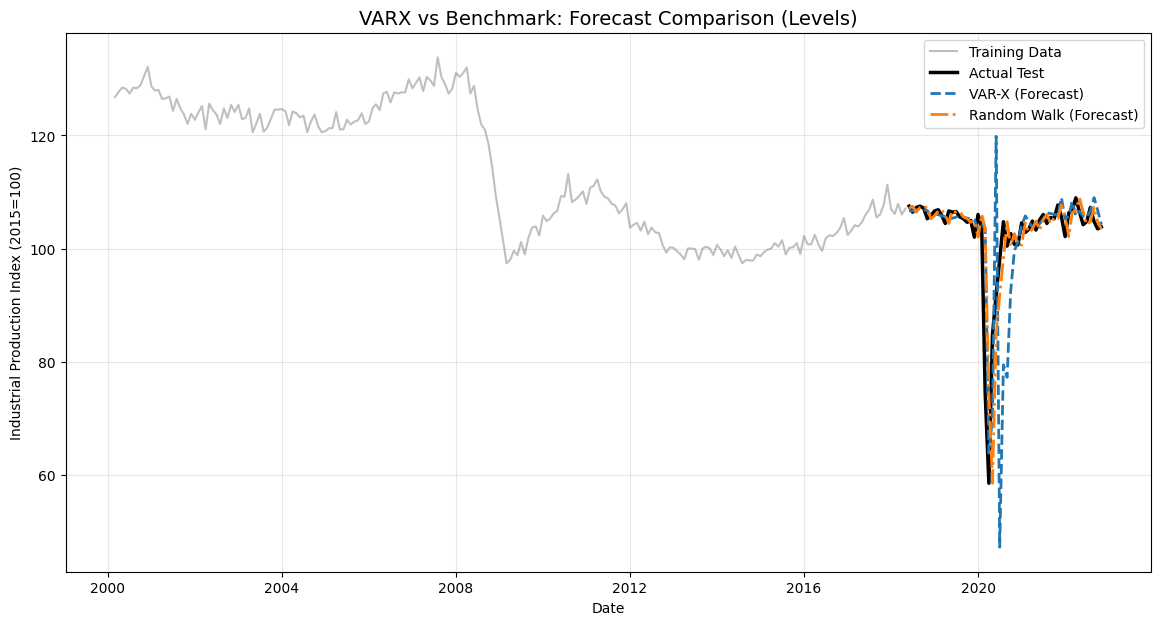

In [26]:
plot_forecasts(
    test=actual_levels,
    predictions_dict=preds_dict,
    train=np.exp(df['LOG_Y_IPI'].iloc[:test_start_index]),
    title="VARX vs Benchmark: Forecast Comparison (Levels)",
    ylabel="Industrial Production Index (2015=100)"
)

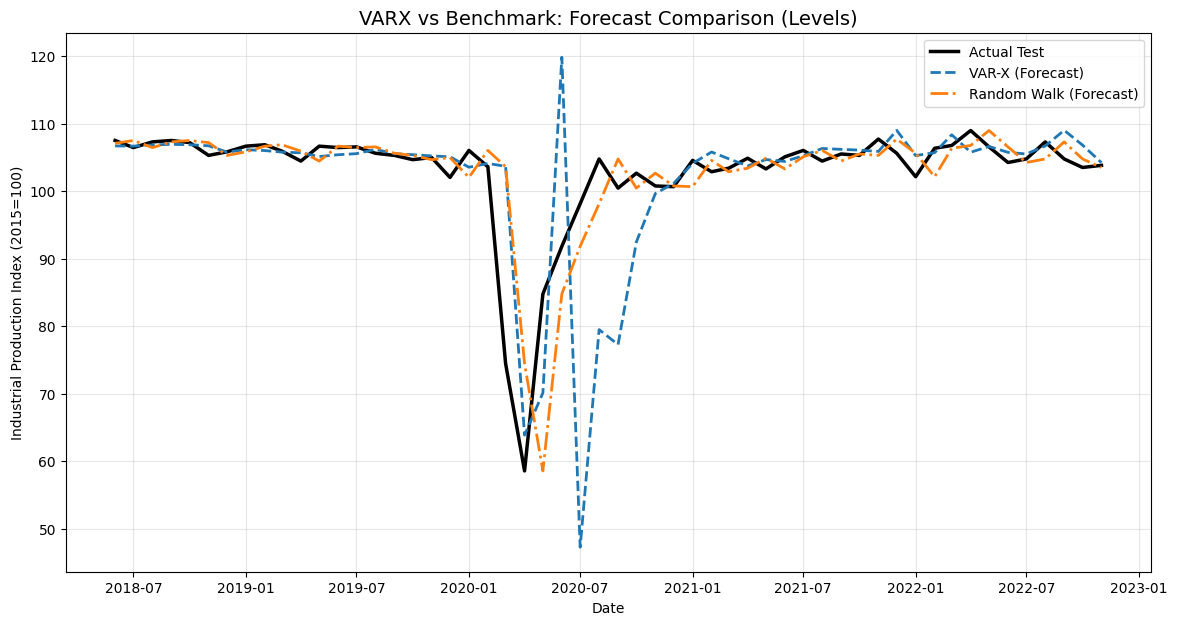

In [27]:
plot_forecasts(
    test=actual_levels,
    predictions_dict=preds_dict,
    train=None,
    title="VARX vs Benchmark: Forecast Comparison (Levels)",
    ylabel="Industrial Production Index (2015=100)"
)

### VAR-X equation definition

To model the joint dependencies between the Italian Industrial Production Index and the set of economic indicators, we specify a **Vector Autoregression (VAR)** model. This approach treats all economic variables as endogenous, allowing for feedback loops between production, prices, and unemployment.

However, to account for the structural breaks caused by the COVID-19 pandemic and the 2008 Financial Crisis without distorting the estimated coefficients, we introduce deterministic dummy variables. This extends the standard VAR into a **VARX (VAR with Exogenous variables)** framework.

#### 1. Variables Definition
Let $\mathbf{y}_t$ be the vector of $k=5$ endogenous variables at time $t$:

$$
\mathbf{y}_t = \begin{bmatrix}
\text{DLOG\_Y\_IPI}_t \\
\text{X\_PPI\_Growth}_t \\
\text{D\_X\_UNEMP}_t \\
\text{DLOG\_X\_OIL}_t \\
\text{LOG\_X\_CLI}_t
\end{bmatrix}
$$

Let $\mathbf{x}_t$ be the vector of $m=2$ exogenous dummy variables at time $t$:

$$
\mathbf{x}_t = \begin{bmatrix}
D_{\text{COVID},t} \\
D_{2008,t}
\end{bmatrix}
$$

#### 2. Model Specification
The evolution of the system is described by the following equation:

$$
\mathbf{y}_t = \mathbf{c} + \sum_{i=1}^{p} \Phi_i \mathbf{y}_{t-i} + \mathbf{B} \mathbf{x}_t + \mathbf{\epsilon}_t
$$

Where:
* $\mathbf{c}$ is a $(k \times 1)$ vector of intercept terms (constants).
* $p$ is the lag order of the model.
* $\Phi_i$ are $(k \times k)$ matrices of autoregressive coefficients for lag $i$.
* $\mathbf{B}$ is a $(k \times m)$ coefficient matrix capturing the contemporaneous impact of the exogenous structural breaks (dummies).
* $\mathbf{\epsilon}_t \sim WN(0, \Omega)$ is a $(k \times 1)$ vector of white noise error terms.

#### 3. Matrix Representation
Expanding the system for our specific variables, the structural equation can be written as:

$$
\begin{bmatrix}
y_{1,t} \\
y_{2,t} \\
\vdots \\
y_{5,t}
\end{bmatrix} = 
\begin{bmatrix}
c_1 \\
c_2 \\
\vdots \\
c_5
\end{bmatrix} + 
\sum_{i=1}^{p}
\begin{bmatrix}
\phi_{11}^{(i)} & \dots & \phi_{15}^{(i)} \\
\vdots & \ddots & \vdots \\
\phi_{51}^{(i)} & \dots & \phi_{55}^{(i)}
\end{bmatrix}
\begin{bmatrix}
y_{1,t-i} \\
y_{2,t-i} \\
\vdots \\
y_{5,t-i}
\end{bmatrix} +
\begin{bmatrix}
\beta_{1, \text{cov}} & \beta_{1, 08} \\
\vdots & \vdots \\
\beta_{5, \text{cov}} & \beta_{5, 08}
\end{bmatrix}
\begin{bmatrix}
D_{\text{COVID},t} \\
D_{2008,t}
\end{bmatrix} + 
\begin{bmatrix}
\epsilon_{1,t} \\
\vdots \\
\epsilon_{5,t}
\end{bmatrix}
$$

This specification allows the model to learn the "normal" economic dynamics via the $\Phi$ matrices while the $\mathbf{B}$ matrix absorbs the mean shifts caused by the exogenous crisis events.

## Random Forest model

### Feature engineering

In [28]:
# We need to shift variables to create predictors (X_t-1, X_t-2...) to predict Y_t

def create_lagged_features(df, target_col, lag_cols, n_lags=3):
    df_lagged = df.copy()
    
    # Create lags for all specified columns
    for col in lag_cols:
        for i in range(1, n_lags + 1):
            df_lagged[f'{col}_lag{i}'] = df[col].shift(i)
    
    # We do NOT lag the dummies (D_COVID, D_2008) because they are deterministic 
    # (we know the date of the forecast, so we know if it's a crisis month or not)
    
    # Drop NaN rows created by shifting
    df_lagged.dropna(inplace=True)
    return df_lagged

# Define which variables to lag (The "Endogenous" ones from before)
vars_to_lag = ['DLOG_Y_IPI', 'X_PPI_Growth', 'D_X_UNEMP', 'DLOG_X_OIL', 'LOG_X_CLI']

# Create Features (Let's use 6 lags = 6 months of memory)
# 6 months is often enough to capture short-term momentum without overfitting
LAG_ORDER = 6
df_features = create_lagged_features(df, target_col='DLOG_Y_IPI', lag_cols=vars_to_lag, n_lags=LAG_ORDER)

# Define X (Features) and y (Target)
target = 'DLOG_Y_IPI'
drop_cols = vars_to_lag + ['LOG_Y_IPI'] # These are the t=0 economic vars
features = [c for c in df_features.columns if c not in drop_cols]
# Note: We exclude the original 'LOG_Y_IPI' level column if it exists, we only want Growth rates and Dummies

print(f"Feature Engineering Complete.")
print(f"Total Features: {len(features)}")
print(f"Features Example: {features[:5]} ...")

Feature Engineering Complete.
Total Features: 32
Features Example: ['D_COVID', 'D_2008', 'DLOG_Y_IPI_lag1', 'DLOG_Y_IPI_lag2', 'DLOG_Y_IPI_lag3'] ...


### Expanding-Window Forecast

In [29]:
# Define Split
n_obs = len(df_features)
n_test = int(len(df) * 0.20) # Keep same test size as before
test_start_index = n_obs - n_test

# Get Ground Truth Levels for evaluation
# Note: We need to align indices carefully because df_features is shorter due to drops
test_indices = df_features.index[test_start_index:]
actual_levels = np.exp(df.loc[test_indices, 'LOG_Y_IPI'])

print(f"Starting Random Forest Forecast (Expanding Window)...")
print(f"Test Range: {test_indices.min()} to {test_indices.max()}")

preds_growth = []
preds_level = []

# Hyperparameters (Simple but robust configuration)
rf_params = {
    'n_estimators': 200,       # Number of trees
    'max_depth': 10,           # Prevent extreme overfitting
    'min_samples_leaf': 2,     # Smooth predictions slightly
    'random_state': 42,
    'n_jobs': -1               # Use all CPU cores
}

for t in range(n_test):
    # 1. Define Train/Test for this step
    # Train: All data up to current step
    # Test: The single next row
    current_train_idx = test_start_index + t
    
    X_train = df_features[features].iloc[:current_train_idx]
    y_train = df_features[target].iloc[:current_train_idx]
    
    X_test = df_features[features].iloc[current_train_idx:current_train_idx+1]
    
    # 2. Fit Model
    model = RandomForestRegressor(**rf_params)
    model.fit(X_train, y_train)
    
    # 3. Forecast Growth
    pred_g = model.predict(X_test)[0]
    preds_growth.append(pred_g)
    
    # 4. Reconstruct Level
    # exp( Last_Actual_Log_Level + Predicted_Growth )
    # The 'Last Actual' is the row BEFORE the current target in the original DF
    # We look up based on the date index of the current prediction step
    current_date = X_test.index[0]
    # Find position in original df
    loc_in_orig = df.index.get_loc(current_date)
    last_log_level = df['LOG_Y_IPI'].iloc[loc_in_orig - 1]
    
    pred_l = np.exp(last_log_level + pred_g)
    preds_level.append(pred_l)
    
    # Progress
    if t % 10 == 0:
        print(f"Step {t}/{n_test} | Prediction: {pred_g:.4f}")

print("Forecast Complete.")

Starting Random Forest Forecast (Expanding Window)...
Test Range: 2018-06-01 00:00:00 to 2022-11-01 00:00:00
Step 0/54 | Prediction: -0.0082
Step 10/54 | Prediction: -0.0010
Step 20/54 | Prediction: -0.0085
Step 30/54 | Prediction: 0.0097
Step 40/54 | Prediction: -0.0046
Step 50/54 | Prediction: -0.0011
Forecast Complete.


### Evaluation and Interpretation


--- Results: Random Forest vs Benchmark ---
                   RMSE
Random Walk    6.235937
Random Forest  6.535279
None


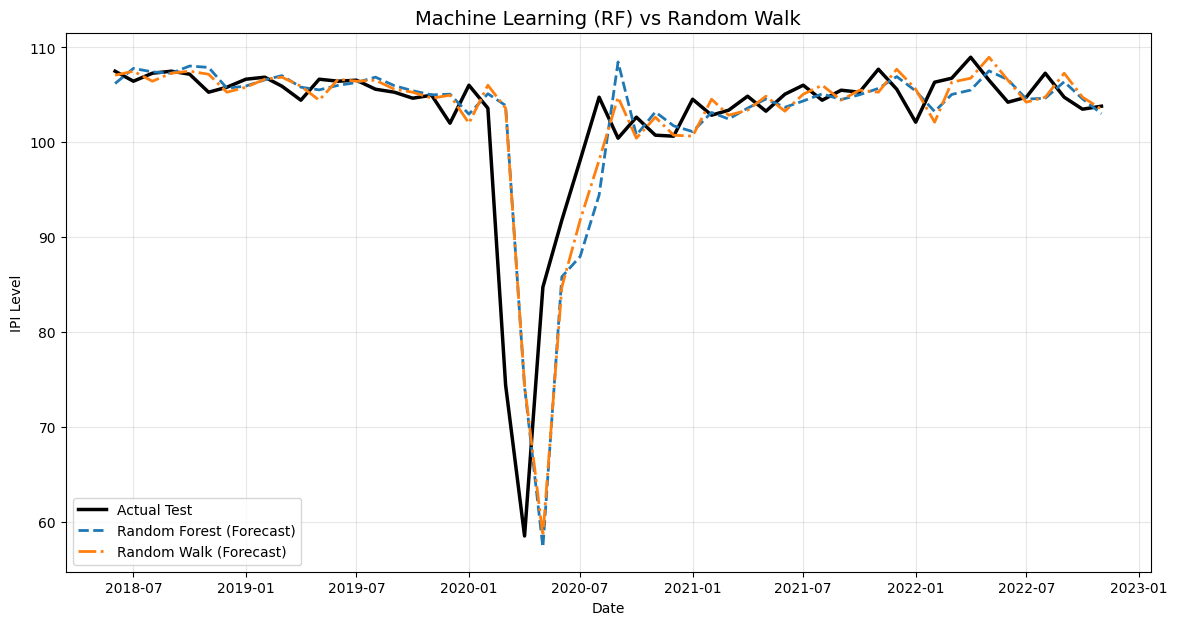

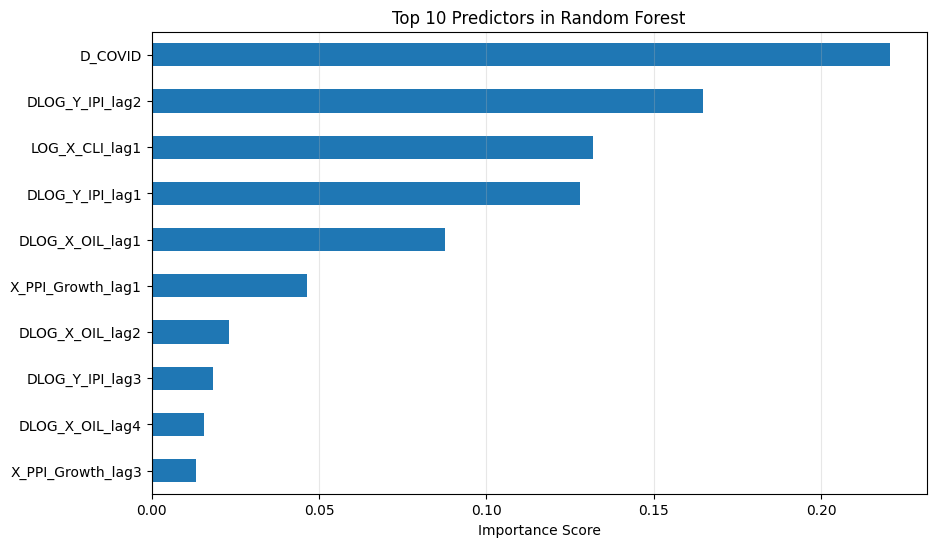

In [32]:
# 1. Prepare Random Walk for Comparison
pred_rw_level = actual_levels.shift(1)
# Fill first value
first_test_date = actual_levels.index[0]
loc_in_orig = df.index.get_loc(first_test_date)
pred_rw_level.iloc[0] = np.exp(df['LOG_Y_IPI'].iloc[loc_in_orig - 1])

# 2. Metrics
preds_dict = {
    'Random Forest': pd.Series(preds_level, index=actual_levels.index),
    'Random Walk': pred_rw_level
}

print("\n--- Results: Random Forest vs Benchmark ---")
metrics_df = compare_metrics(actual_levels, preds_dict)
print(metrics_df)

# 3. Plot Forecasts
plot_forecasts(
    test=actual_levels, 
    predictions_dict=preds_dict,
    title="Machine Learning (RF) vs Random Walk",
    ylabel="IPI Level"
)

# 4. Feature Importance Plot
# What actually drove the decisions?
importance = pd.Series(model.feature_importances_, index=features)
importance = importance.sort_values(ascending=False).head(10) # Top 10

plt.figure(figsize=(10, 6))
importance.plot(kind='barh', color='#1f77b4')
plt.title('Top 10 Predictors in Random Forest')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis() # Highest at top
plt.grid(axis='x', alpha=0.3)
plt.show()

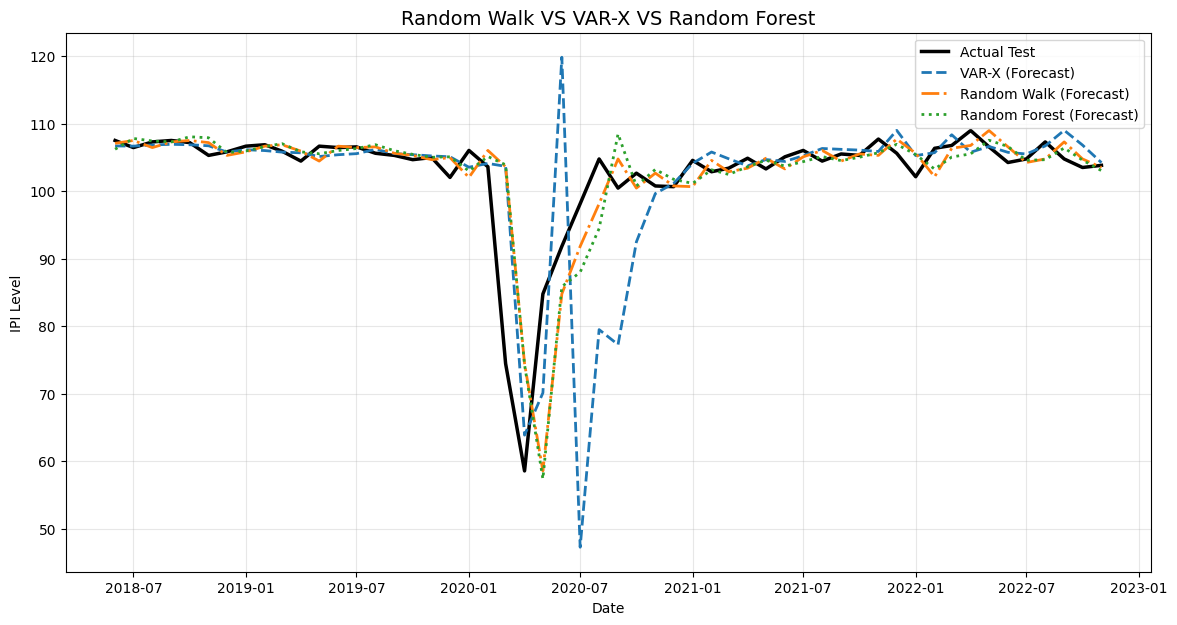


--- Results: Random Forest vs Benchmark ---
                    RMSE
Random Walk     6.235937
Random Forest   6.535279
VAR-X          10.427251
None


In [33]:
final_preds = {
    'VAR-X': varx_series,
    'Random Walk': pred_rw_level,
    'Random Forest': pd.Series(preds_level, index=actual_levels.index)}

plot_forecasts(
    test=actual_levels, 
    predictions_dict=final_preds,
    title="Random Walk VS VAR-X VS Random Forest",
    ylabel="IPI Level"
)

print("\n--- Results: Random Forest vs Benchmark ---")
final_metrics = compare_metrics(actual_levels, final_preds)
print(final_metrics)
